### 加载模型推理预测结果

#### 加载预训练模型

In [1]:
from tools import inference_img
from dataset_tools import ADE20KDataset
from dataset_tools import TensorDataset
from mmseg.apis import init_segmentor
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from tqdm import tqdm
import torch
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette



pspnet_config_file = '../configs/pspnet/pspnet_r50-d8_512x512_80k_ade20k.py'
pspnet_checkpoint_file = '../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth'
pspnet_model = init_segmentor(pspnet_config_file, pspnet_checkpoint_file, device='cuda:0')
    

fcn_config_file = '../configs/fcn/fcn_r50-d8_512x512_80k_ade20k.py'
fcn_checkpoint_file = '../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth'
fcn_model = init_segmentor(fcn_config_file, fcn_checkpoint_file, device='cuda:0')


deeplabv3plus_config_file = '../configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py'
deeplabv3plus_checkpoint_file = '../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'
deeplabv3plus_model = init_segmentor(deeplabv3plus_config_file, deeplabv3plus_checkpoint_file, device='cuda:0')


device = 'cuda:0'

test_tensor_path = '/root/Desktop/我的网盘/inference_tensor_test/'
test_img_path = '/root/Desktop/我的网盘/test_set/img_test/'
test_label_path = '/root/Desktop/我的网盘/test_set/label/'

test_tensor_dataset = TensorDataset(test_tensor_path, test_label_path, device)
test_img_dataset = ADE20KDataset(test_img_path, test_label_path)

/root/Desktop/mmsegmentation-master/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth
load checkpoint from local path: ../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth
load checkpoint from local path: ../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth


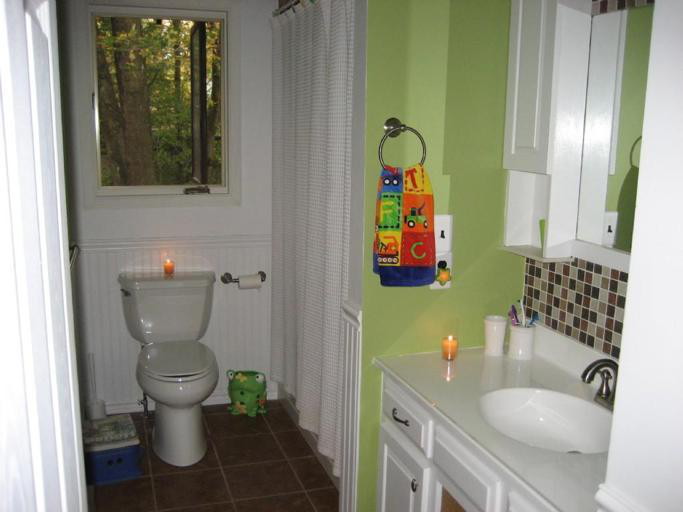

In [46]:
import matplotlib.pyplot as plt
from PIL import Image

idx = 20

original_img, label = test_img_dataset[idx]
original_img.show()

In [47]:
import numpy as np

img_path = test_img_dataset.get_img_path(idx)
label = test_img_dataset.get_label_as_PIL(idx)
label = np.array(label, dtype = np.uint8)

pspnet_result = np.array(inference_segmentor(pspnet_model, img_path)[0]).astype(np.uint8)
fcn_result = np.array(inference_segmentor(fcn_model, img_path)[0]).astype(np.uint8)
deeplabv3p_result = np.array(inference_segmentor(deeplabv3plus_model, img_path)[0]).astype(np.uint8)

In [48]:
deeplabv3p_result

array([[14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0],
       ...,
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0]], dtype=uint8)

In [49]:
pspnet_result_img = Image.fromarray(pspnet_result)
fcn_result_img = Image.fromarray(fcn_result)
deeplabv3p_result_img = Image.fromarray(deeplabv3p_result)

#### 加载EnSeg模型，推理fusion结果

In [50]:
from Ensemble_model import FusionModel
model = torch.load('/root/Desktop/我的网盘/fusion_model_100.pth')   
model = model.to('cuda:0')

tensor_dict, annotation_tensor = test_tensor_dataset[0]
annotation_tensor -= 1 # 忽略背景类，将label范围从1-150变为0-149
    
deeplabv3p_logits_res = tensor_dict['deeplabv3p'].to(device)
pspnet_logits_res = tensor_dict['pspnet'].to(device)
fcn_logits_res = tensor_dict['fcn'].to(device)

res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res) # (150, H, W)
enseg_result = res.argmax(0).cpu().numpy().astype(np.uint8)

In [51]:
enseg_result_img = Image.fromarray(enseg_result)

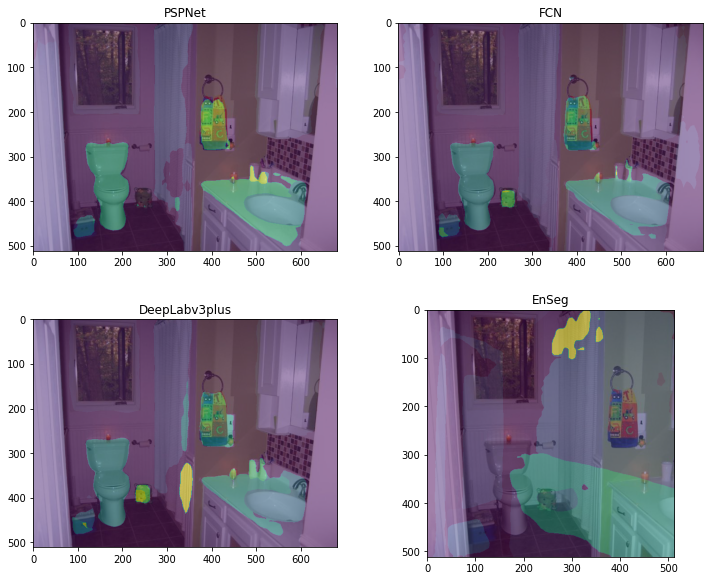

In [52]:
plt.figure(figsize=(12, 10))
 
plt.subplot(221)
plt.imshow(original_img)
plt.imshow(pspnet_result_img,alpha=0.5)
plt.title("PSPNet")
 
plt.subplot(222)
plt.imshow(original_img)
plt.imshow(fcn_result_img,alpha=0.5)
plt.title("FCN")

plt.subplot(223)
plt.imshow(original_img)
plt.imshow(deeplabv3p_result_img,alpha=0.5)
plt.title("DeepLabv3plus")
 
plt.subplot(224)
plt.imshow(original_img)
plt.imshow(enseg_result_img,alpha=0.5)
plt.title("EnSeg")

plt.show()